In [1]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torh # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [2]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [3]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from unsloth import FastVisionModel
import torch

from collections import Counter
pd.options.display.max_rows = 5

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [4]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [5]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test


In [6]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [7]:
# Vast majority of images consists of 2 images. Let's assume we select only the first 2. Ideally, need to generalize this later.

def count_images_in_folder(folder_path):

    count = sum(1 for file in folder_path.iterdir() if file.suffix.lower() in {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"} )
    return count

images_count = {folder_id: count_images_in_folder(path_images / folder_id) for folder_id in ids_annot}

Counter(images_count.values())

Counter({2: 2519, 3: 136, 4: 4})

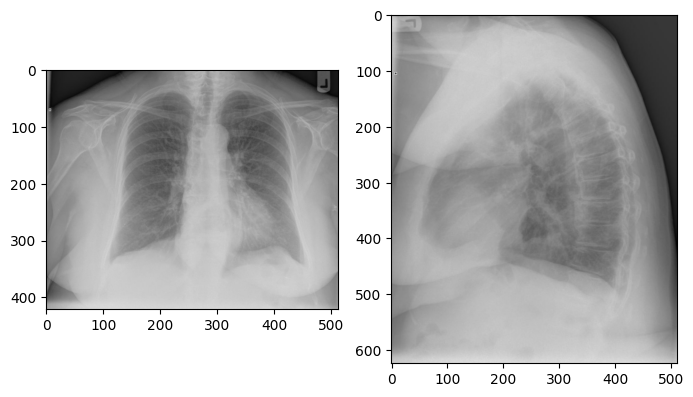

In [8]:
# Plot manually selected id. Images are various sizes.

fig, axes = plt.subplots(1, 2, figsize=(7, 4))
for ax, image_filename in zip(axes, ["0.png", "1.png"]):
    path_image = path_images / ids_annot[0] / image_filename
    img = Image.open(path_image)
    ax.imshow(img)

plt.tight_layout()

In [9]:
sizes = []

for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")

        sizes.append({'id': folder_id,
                      'img0_w': img0.size[0], 'img0_h': img0.size[1],
                      'img1_w': img1.size[0], 'img1_h': img1.size[1] })
    except FileNotFoundError as e:
        print(f"File not found: {e}")

sizes = pd.DataFrame(sizes).set_index('id')
sizes

  0%|          | 0/2659 [00:00<?, ?it/s]

,img0_w,img0_h,img1_w,img1_h
id,,,,
CXR2384_IM-0942,512,420,512,624
CXR2926_IM-1328,512,512,512,562
...,...,...,...,...
CXR2312_IM-0887,512,624,512,624
CXR49_IM-2110,512,420,512,624


In [10]:
# Widths of images 0 and 1 are the same 512. Can concatinate based on the same widths for training/testing

sizes['img0_w'].value_counts(dropna=False), sizes['img1_w'].value_counts(dropna=False)

(img0_w
 512    2659
 Name: count, dtype: int64,
 img1_w
 512    2659
 Name: count, dtype: int64)

In [11]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [12]:
# This df is complete withoyt nans
df_data.isnull().any().any()

False

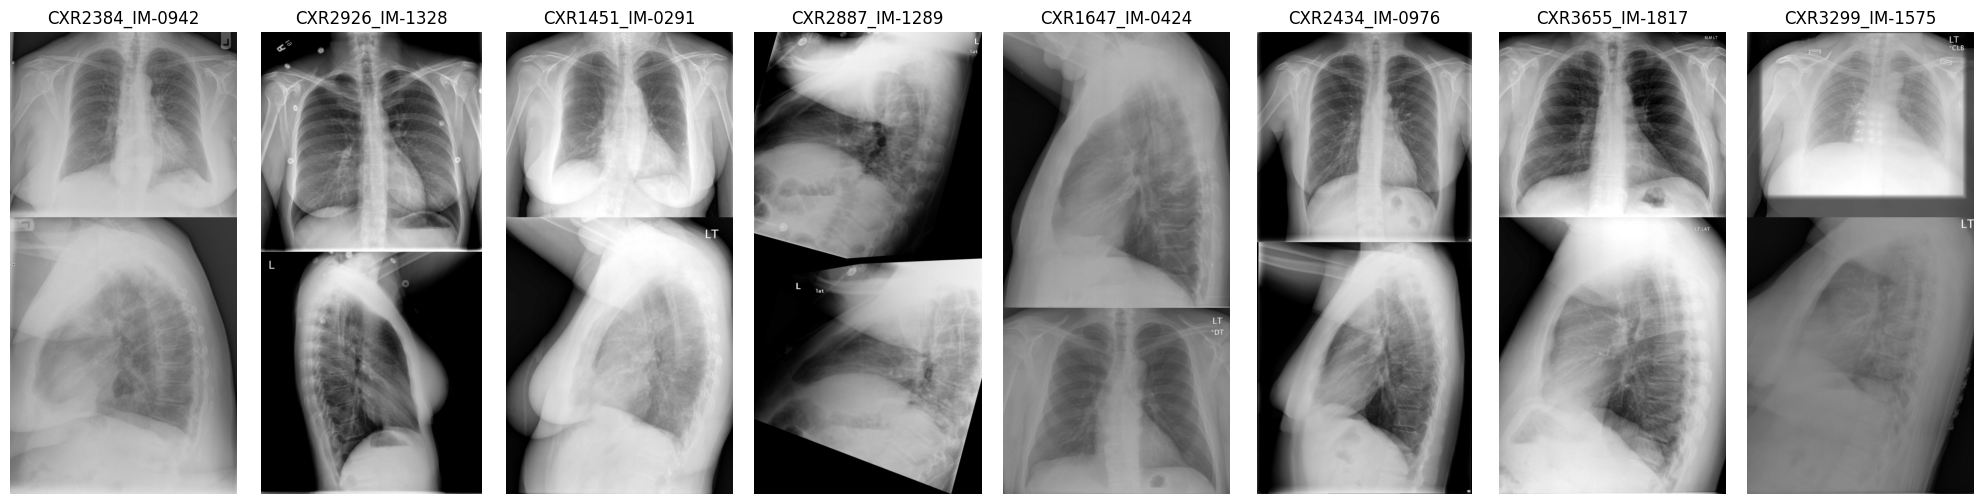

In [13]:
# Plot the first 8 images

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 5))
for i, (index, row) in enumerate(df_data.iloc[:8, :].iterrows()):

    ax = axes[i]
    ax.imshow(row['image'])
    ax.set_title(index); ax.axis('off')
plt.tight_layout()

- Notice, some images require a special attention, like CXR2887_IM-1289. Because of the time constraint, lets' keep moving for now and not pre-proicess images manually.
- In some cases, it is first Lateral, then Frontal images are concatinated (CXR1647_IM-0424). I keep it like this for now, but needs to be modified to unify the way we present images for the model to train, and normalized.
- The other issue - is the scale of images. In CV a unified scale ensures that all images fed into the model have the same dimensions, which can help the model learn more effectively by reducing variability that isn't relevant to the task.


In [14]:
# Quite a lot of fields are empty in the reports, especially the "bone" and "others". Below %

df_report = df_data['report'].apply(pd.Series).replace(['', ' ', '  '], None)
df_report.isnull().sum(axis=0)*100 / len(df_report)

bone           44.076721
heart           2.068447
lung            0.075216
mediastinal    21.850320
others         65.513351
dtype: float64

**Llama-3.2-11B-Vision-Instruct:** 
- "Note: The vision models do not support the system role."
- Wil lget - TemplateError: Prompting with images is incompatible with system messages. 

In [15]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

def conversations(row):

   report_text = " ".join(["%s: %s" % (k, v) for k, v in row['report'].items() if v])

   conversation = [ {  "role": "user",
                     "content": [ {"type": "text", "text": instruction_user},
                                    {"type": "image", "image": row["image"]},],},

                    {  "role": "assistant",
                     "content": [{"type": "text", "text": report_text}]}]

   return {"messages": conversation}

In [16]:
data_train = [  conversations(row) for _, row in df_data.loc[df_data['split'] == 'train', :].iterrows()  ]
data_test  = [  conversations(row) for _, row in df_data.loc[df_data['split'] == 'test',  :].iterrows()  ]

data_test[45]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "\nYou are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.\nYour goal is to analyze X-ray images and write diagnostic reports based on X-ray images.\nYou only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.\nEach report may not necessarily include findings for all regions. Some regions might be empty.\nYou are provided with a chest X-ray image.\nWrite a radiology report accurately by looking at the image provided.\nEach image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.\nWrite the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.\n"},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x1044>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'heart: The cardiac contours

- Notice, I intentionally keep keys of the report findings for the training/testing purposes - lung, heart, mediastinal, bone, and others
- This is because the more information you provide to the model, the better the training. Especially, when the data is well organized into 4 anatomical categories.

In [17]:
len(data_train), len(data_test)

(2069, 590)

# Fine-tuning

In [18]:
name_model = "Llama-3.2-11B-Vision-Instruct" 

model, tokenizer = FastVisionModel.from_pretrained( "unsloth/" + name_model, 
                                                   load_in_4bit = True,
                                                   use_gradient_checkpointing = "unsloth")

==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.48.1.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
# Setting up the PEFT (Parameter-Efficient Fine-Tuning) includes LoRA (Low-Rank Adaptation) 

model = FastVisionModel.get_peft_model(
            model,
            finetune_vision_layers    = True,
            finetune_language_layers  = True,
            finetune_attention_modules= True,
            finetune_mlp_modules      = True,
            r = 16,
            lora_alpha = 16,
            lora_dropout = 0,
            bias = "none",
            random_state = 3443,
            use_rslora = False,
            loftq_config = None )

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


In [20]:
from unsloth import is_bf16_supported # 16-bit fl-point format to improve performance/memory
from unsloth.trainer import UnslothVisionDataCollator # preparing/collating data for vision tasks
from trl import SFTTrainer, SFTConfig

In [23]:
%%time

# Enable "model" for training
FastVisionModel.for_training(model)  

trainer = SFTTrainer(model=model, tokenizer=tokenizer, 
                     data_collator=UnslothVisionDataCollator(model, tokenizer),  
                     train_dataset=data_train, 
                     args=SFTConfig(per_device_train_batch_size=2,
                                    gradient_accumulation_steps=4,
                                    warmup_steps=5,
                                    #max_steps=60,       # either this or num_train_epochs
                                    num_train_epochs=1,  # full pass over your dataset [1:3 max]
                                    learning_rate=2e-4,
                                    fp16=not is_bf16_supported(),
                                    bf16=is_bf16_supported(),
                                    logging_steps=5,
                                    optim="adamw_8bit",
                                    weight_decay=0.01,
                                    lr_scheduler_type="linear",
                                    seed=3407,
                                    output_dir="outputs",
                                    report_to="none",  # for weights and biases
                                    remove_unused_columns=False,
                                    dataset_text_field="",
                                    dataset_kwargs={"skip_prepare_dataset": True},
                                    dataset_num_proc=4,
                                    max_seq_length=2048))

trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,069 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 258
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,2.979400
10,1.574800
15,0.577300
20,0.442800
25,0.419000
30,0.377900
35,0.348500
40,0.358700
45,0.324500
50,0.276200


CPU times: user 1h 4min 37s, sys: 31min 45s, total: 1h 36min 22s
Wall time: 1h 33min 51s


In [26]:
trainer_stats

TrainOutput(global_step=258, training_loss=0.3719192419865335, metrics={'train_runtime': 5628.9018, 'train_samples_per_second': 0.368, 'train_steps_per_second': 0.046, 'total_flos': 2.873851950477389e+16, 'train_loss': 0.3719192419865335, 'epoch': 0.9971014492753624})

In [24]:
# Save the model and tokenizer locally

name_finetuned = name_model + "_finetuned_" + "xray_report"

model.save_pretrained(name_finetuned) 
tokenizer.save_pretrained(name_finetuned)

import shutil
shutil.make_archive(name_finetuned, 'zip', name_finetuned)

'/home/transformers_xray_report/Llama-3.2-11B-Vision-Instruct_finetuned_xray_report.zip'

In [25]:
# Push models to the Hugging Face Hub

# !pip install --upgrade huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

model.push_to_hub( "Aidan777/"    + name_finetuned) 
tokenizer.push_to_hub("Aidan777/" + name_finetuned) 

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Aidan777/Llama-3.2-11B-Vision-Instruct_finetuned_xray_report


  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]